In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

train_losses = []
test_losses = []


In [10]:
# Düzeltmeleri yaparak LeNet-5 modelini tekrar tanımlayalım ve eğitelim

class LeNet5Corrected(nn.Module):
    def __init__(self):
        super(LeNet5Corrected, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # This might need to be adjusted
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Cihazı ayarlayın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli, kayıp fonksiyonunu ve optimizatörü 'device' ile uyumlu hale getirin
model_corrected = LeNet5Corrected().to(device)
criterion_corrected = nn.CrossEntropyLoss()
optimizer_corrected = optim.SGD(model_corrected.parameters(), lr=0.001, momentum=0.9)

epochs = 10
# Eğitim döngüsü
for epoch in range(epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        # forward
        scores = model_corrected(data)
        loss = criterion_corrected(scores, targets)

        # backward
        optimizer_corrected.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer_corrected.step()
        test_losses.append(loss.item())

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')



# Modelin doğruluğunu kontrol etme fonksiyonunu yeniden kullanalım
def check_accuracy_corrected(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

train_acc = check_accuracy_corrected(train_loader, model_corrected)
test_acc = check_accuracy_corrected(test_loader, model_corrected)
print(f"Accuracy on training set: {train_acc * 100:.2f}")
print(f"Accuracy on test set: {test_acc * 100:.2f}")

# Modeli kaydedelim
torch.save(model_corrected.state_dict(), 'lenet5_corrected.pth')
print("Corrected model saved to lenet5_corrected.pth")



Epoch 1, Loss: 0.46158739924430847
Epoch 2, Loss: 0.3280697464942932
Epoch 3, Loss: 0.12477871775627136
Epoch 4, Loss: 0.02383393608033657
Epoch 5, Loss: 0.03214043006300926
Epoch 6, Loss: 0.2649572491645813
Epoch 7, Loss: 0.05666590481996536
Epoch 8, Loss: 0.1161004900932312
Epoch 9, Loss: 0.07301682233810425
Epoch 10, Loss: 0.026977000758051872
Accuracy on training set: 98.37
Accuracy on test set: 98.10
Corrected model saved to lenet5_corrected.pth


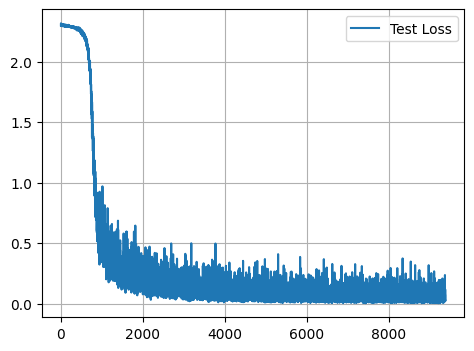

In [12]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.grid()
plt.show()
